In [1]:
#packages
import pandas as pd
import pickle
import csv
import os
import re
import emoji
from textblob import TextBlob
import nltk
from langdetect import detect
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import gensim
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix
import sklearn
from scipy import spatial
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
import gensim.downloader
import fasttext

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luoyu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luoyu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [349]:
#import sentiments prediction result from lstm
lstm_pred = pd.read_csv(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\lstm_pred\LSTM_prediction.csv")
lstm_pred = lstm_pred[lstm_pred['combined_tweet_txt'].notna()]
lstm_pred = lstm_pred.drop_duplicates(subset='combined_tweet_txt', keep="last")
list_of_txt = list(lstm_pred["combined_tweet_txt"])

In [351]:
lstm_pred = pd.read_csv(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\lstm_pred\LSTM_prediction.csv")
#lstm_pred = lstm_pred.drop_duplicates(subset='combined_tweet_txt', keep="last")
print(len(lstm_pred))
lstm_pred_negative = lstm_pred.copy().loc[lstm_pred['prediction'] == -1]
len(lstm_pred_negative)

357474


85471

In [352]:
len(lstm_pred)

357474

In [339]:
lstm_pred['word_len'] = lstm_pred['combined_tweet_txt'].str.len()
frequency = [len(lstm_pred)]
difference = []
word_cutoff = [10,20,30,40,50,60,70,80,90,100]
for i in range(len(word_cutoff)):
    lstm_pred = lstm_pred[lstm_pred.word_len > word_cutoff[i]]
    frequency.append(len(lstm_pred))
    difference.append(frequency[i]-len(lstm_pred))

In [348]:
lstm_pred['word_len'] = lstm_pred['combined_tweet_txt'].str.len()
lstm_pred = lstm_pred[lstm_pred.word_len > 50]
lstm_pred.to_excel('./cutoff50.xlsx')

<ipython-input-348-82435b2daf4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_pred['word_len'] = lstm_pred['combined_tweet_txt'].str.len()


Text(0, 0.5, 'Number of tweets left')

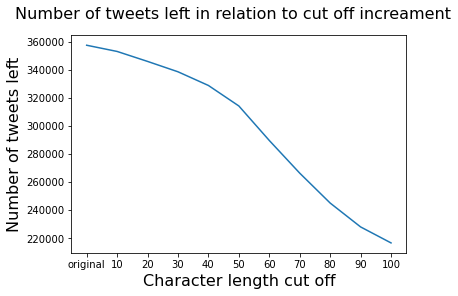

In [342]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(['original',10,20,30,40,50,60,70,80,90,100],frequency)
fig.suptitle('Number of tweets left in relation to cut off increament', fontsize=16)
plt.xlabel('Character length cut off', fontsize=16)
plt.ylabel('Number of tweets left', fontsize=16)

In [42]:
#train word2vec with Gensim and import glove
tokens = [nltk.word_tokenize(sentences) for sentences in list_of_txt]
model = gensim.models.Word2Vec(tokens, min_count=1, size=200) 
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

glove_vectors = gensim.downloader.load('glove-twitter-200')
glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))
w2v.update(glove_vectors_w2v)

<ipython-input-42-f8a12a8bd67d>:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  w2v = dict(zip(model.wv.index2word, model.wv.syn0))
<ipython-input-42-f8a12a8bd67d>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))
<ipython-input-42-f8a12a8bd67d>:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))


In [4]:
# train word2vec with Fasttext
from gensim.models import FastText
#FasTxt = FastText(list_of_txt, size=25)
#w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [5]:
tokens = [nltk.word_tokenize(sentences) for sentences in list_of_txt]
model = FastText(tokens, min_count=1, size=25) 
FasTxt = dict(zip(model.wv.index2word, model.wv.syn0))
glove_vectors = gensim.downloader.load('glove-twitter-25')
glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))
FasTxt.update(glove_vectors_w2v)

<ipython-input-5-436c5a515c25>:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  FasTxt = dict(zip(model.wv.index2word, model.wv.syn0))
<ipython-input-5-436c5a515c25>:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))
<ipython-input-5-436c5a515c25>:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))


In [7]:
#sentence embedding
def embedding(list_of_txt, model,size):
    Tfidf_model = TfidfVectorizer()
    Tfidf_model.fit(list_of_txt)
    tf_idf_dict = dict(zip(Tfidf_model.get_feature_names(), list(Tfidf_model.idf_)))
    documents = []
    for count,tweet in enumerate(list_of_txt):
    #word_vectors = []
        weight_sum = 0
        for word in tokens[count]: # or your logic for separating tokens
            sent_vec = np.zeros(size)
            if word in tf_idf_dict:
                tf_idf_score = tf_idf_dict[word]
                sent_vec += model[word]*tf_idf_score
                weight_sum += tf_idf_score
                #word_vectors.append(sent_vec)
        if weight_sum != 0:
            sent_vec /= weight_sum
        documents.append(sent_vec)
    return documents 
documents = embedding(list_of_txt,FasTxt,25)

In [8]:
##add word2vec vectors to lstm_pred column
lstm_pred['wordvec'] = documents
##filter the negative sentiment tweets
lstm_pred_negative = lstm_pred.copy().loc[lstm_pred['prediction'] == -1]
lstm_pred_negative['word_len'] = lstm_pred_negative['combined_tweet_txt'].str.len()
lstm_pred_negative.to_excel('lstm_pred_negative.xlsx')

# binary Classification

In [238]:
#biclass classification
def train_model(classifier, feature_vector_train, label, feature_vector_valid,valid_y,thresh):
    classifier.fit(feature_vector_train, label)
    predicted_proba = classifier.predict_proba(feature_vector_valid)
    predictions = (predicted_proba [:,1] >= thresh).astype('int')
    
    labels = np.unique(label)

    report = classification_report(valid_y,predictions,labels = labels,output_dict =True)
    
    return report

def train_classifier(X_train, y_train, X_valid,valid_y,thresh):
    report_list=[]
    for classifier, flag in zip(test_classifiers, test_classifiers_flag):
        report=train_model(classifier, X_train, y_train, X_valid,valid_y,thresh)
        #print('------------------The report of',flag,'--------------------')
        #print(report)
        #print(conf)
        report_list.append((flag,report))
    return report_list

def StratifiedSampling(df, test_size):
    X = df.drop(['y'], axis=1)
    y = df.y
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)    
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
    return train,test

def splitandtrain(df,thresh):
    train,test = StratifiedSampling(df, 0.5)
    train_x = list(train.wordvec)
    train_y = list(train.y)
    valid_x = list(test.wordvec)
    valid_y = list(test.y)
    report_list = train_classifier(train_x, train_y, valid_x,valid_y,thresh)
    return report_list

#get average classification stats by running split and train for 10 times. 
####cluster_df_1: a dataset df including training and testing
####thresh: probability threshold
def ave_score(cluster_df_1, thresh):
    precision_list, recall_list, f1_list, accuracy_list = [],[],[],[]
    for i in range(10):
        flag = test_classifiers_flag[0]
        report = splitandtrain(cluster_df_1[['y','wordvec']],thresh)[0]
        precision_list.append(report[1]['1']['precision'])
        recall_list.append(report[1]['1']['recall'])
        f1_list.append(report[1]['1']['f1-score'])
        accuracy_list.append(report[1]['accuracy'])
    print('-----------------',thresh,'-------------------')
    print('precision:', sum(precision_list)/len(precision_list))
    print('recall:', sum(recall_list)/len(recall_list))
    print('f1:', sum(f1_list)/len(f1_list))
    print('accuracy:', sum(accuracy_list)/len(accuracy_list))
    return sum(precision_list)/len(precision_list)

In [247]:
#pick the class for binary classification and prepare training data
cluster_df_sample_6x100 = pd.read_excel(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\cluster_df_sample_6x100.xlsx")

bilabel = [1 if i==3 else 0 for i in list(cluster_df_sample_6x100.true_class)]
selected_class_num = sum(bilabel)
for_join = cluster_df_sample_6x100[['combined_tweet_txt']]
cluster_df_1 = for_join.set_index('combined_tweet_txt').join(lstm_pred_negative.set_index('combined_tweet_txt'), how='left')
cluster_df_1['y'] = bilabel
bilabel_cluster_df = cluster_df_1.copy()
selected_class_tweets = cluster_df_1[cluster_df_1.y == 1]
other_class_tweets = cluster_df_1[cluster_df_1.y == 0]
cluster_df_1 = selected_class_tweets.append(other_class_tweets.sample(selected_class_num))
#RF_report,LR_report = splitandtrain(cluster_df_1[['y','wordvec']],0.5)

In [241]:
ave_score(cluster_df_1, 0.5)

----------------- 0.5 -------------------
precision: 0.6060673482116548
recall: 0.5611111111111111
f1: 0.5824251758555928
accuracy: 0.6013793103448276


0.6060673482116548

# baseline majority

In [249]:
#biclass classification
def train_model(classifier, feature_vector_train, label, test_x):
    classifier.fit(feature_vector_train, label)  
    predicted_proba_all = classifier.predict_proba(test_x)
    return predicted_proba_all[:,1]

def StratifiedSampling(df, test_size):
    X = df.drop(['true_class'], axis=1)
    y = df.true_class
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)    
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
    return train,test

def splitandtrain(train,test):
    train_x = list(train.wordvec)
    train_y = list(train.y)
    test_x = list(test.wordvec)
    classifier = test_classifiers[0]
    predictions=train_model(classifier, train_x, train_y,test_x)
    return predictions

#get average classification stats by running split and train for 10 times. 
####cluster_df_1: a dataset df including training and testing
####thresh: probability threshold
def ave_score(cluster_df_1, whole_cluster_df):
    precision_list, recall_list, f1_list, accuracy_list = [],[],[],[]
    predictions_list = []
    for i in range(10):
        flag = test_classifiers_flag[0]
        predictions = splitandtrain(cluster_df_1[['y','wordvec']], whole_cluster_df)
        #print(predictions)
        predictions_list.append(predictions)

    average_predication = [sum(i)/len(i) for i in list(map(list, zip(*predictions_list)))]
    return average_predication

In [170]:
#classification methods
RF = RandomForestClassifier()
LR = LogisticRegressionCV(cv=5, random_state=0,max_iter=1000)
test_classifiers = [RF,LR]
test_classifiers_flag = ['RF','LR']

In [250]:
cluster_df_sample_6x100 = pd.read_excel(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\cluster_df_sample_6x100.xlsx")
cluster_df_sample_6x100 = cluster_df_sample_6x100[['combined_tweet_txt','true_class']]
top_ambiguous = pd.read_excel(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\top_ambiguous.xlsx")
cluster_df_sample_6x100 = cluster_df_sample_6x100.append(top_ambiguous[['combined_tweet_txt','true_class']])
##remove positive sentiments 
cluster_df_sample_6x100 = cluster_df_sample_6x100[cluster_df_sample_6x100.true_class != 0]
for_join = cluster_df_sample_6x100[['combined_tweet_txt','true_class']]
##join to get word vectors
cluster_df = for_join.set_index('combined_tweet_txt').join(lstm_pred_negative.set_index('combined_tweet_txt'), how='left')
prediction_list=[]
train,test = StratifiedSampling(cluster_df, 0.5)
for label in range(6):
    bilabel_cluster_df = train.copy()
    bilabel = [1 if i==label+1 else 0 for i in list(bilabel_cluster_df.true_class)]
    selected_class_num = sum(bilabel)
    bilabel_cluster_df['y'] = bilabel
    selected_class_tweets = bilabel_cluster_df[bilabel_cluster_df.y == 1]
    other_class_tweets = bilabel_cluster_df[bilabel_cluster_df.y == 0]
    bilabel_cluster_df_sample = selected_class_tweets.append(other_class_tweets.sample(selected_class_num))
    prediction = ave_score(bilabel_cluster_df_sample,test)
    print(selected_class_num)
    prediction_list.append(prediction)

23
38
87
42
7
9


In [207]:
multi_prediction = [values.index(max(values))+1 for values in list(map(list, zip(*prediction_list)))]
multiclassScore(list(test.true_class), multi_prediction)

([0.24,
  0.2777777777777778,
  0.6785714285714286,
  0.21428571428571427,
  0.041666666666666664,
  0.06451612903225806],
 0.30917874396135264)

# multiclass

In [258]:
#Multiclass classification
def train_models_multi(X_train,y_train,model):
    clf = RandomForestClassifier()
    clf = clf.fit(X_train, y_train)
    return clf

def multi_classifier(X_train,y_train,X_test,model):
    p_list = []
    fin_pred = []
    fin_pred_list = []
    clf = train_models_multi(X_train,y_train,model=model)
    predication = clf.predict(X_test)  
    return predication

def StratifiedSampling(df, test_size):
    X = df.drop(['y'], axis=1)
    y = df.y
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)    
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
    return train,test

def splitandtrain(df):
    train,test = StratifiedSampling(df, 0.5)
    train_x = list(train.wordvec)
    train_y = train.y
    valid_x = list(test.wordvec)
    valid_y = test.y
    X_test = list(df.wordvec)
    predication = multi_classifier(train_x,train_y,valid_x,model)
    #print(multiclassScore(list(test.y), predication))
    return multiclassScore(list(test.y), predication)

def splitandtrain_second_classifer(df):
    train,test = StratifiedSampling(df, 0.5)
    train_x = train.drop(['y'], axis=1)
    train_y = train.y
    valid_x = test.drop(['y'], axis=1)
    valid_y = test.y
    X_test = df.drop(['y'], axis=1)
    predication = multi_classifier(train_x,train_y,valid_x,model)
    #print(multiclassScore(list(test.y), predication))
    return multiclassScore(list(test.y), predication)

def ave_score(df, approach):
    class_proability_list,accuracy_list = [],[]
    predictions_list = []
    for i in range(10):
        if approach == 1:
            result = splitandtrain(df)
        if approach == 2:
            result = splitandtrain_second_classifer(df)
    class_proability_list.append(result[0])
    accuracy_list.append(result[1])
    
    average_proability = [sum(i)/len(i) for i in list(map(list, zip(*class_proability_list)))]
    return average_proability, sum(accuracy_list)/len(accuracy_list)

In [252]:
#multiclass classification
classifiers = ['random_forest']
cluster_df['y'] = list(cluster_df_sample_6x100.true_class)
multi_prediction = ave_score(cluster_df[['y','wordvec']],1)

C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

In [236]:
multi_prediction

([0.25, 0.16666666666666666, 0.55, 0.2857142857142857, 0.0, 0.0],
 0.41346153846153844)

In [ ]:
splitandtrain(df)

In [235]:
#sencond classifier
second_classifier = pd.DataFrame(list(map(list, zip(*prediction_list))), columns = ['1', '2','3','4','5','6'])  
second_classifier['y'] = list(test.true_class)
multi_prediction = ave_score(second_classifier,2)

C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

In [237]:
second_classifier

,1,2,3,4,5,6,y
0,0.072,0.292,0.977,0.079,0.662,0.627,3
1,0.660,0.472,0.513,0.211,0.513,0.705,4
2,0.751,0.733,0.703,0.229,0.730,0.573,4
3,0.690,0.381,0.411,0.601,0.404,0.505,1
4,0.466,0.392,0.763,0.637,0.475,0.597,3
...,...,...,...,...,...,...,...
202,0.384,0.453,0.545,0.479,0.664,0.425,3
203,0.535,0.331,0.111,0.660,0.468,0.315,4
204,0.602,0.482,0.432,0.522,0.409,0.421,3
205,0.488,0.639,0.468,0.351,0.653,0.570,4


# testing 

In [266]:
def multiclassScore(true_label, multi_prediction):
    print(multi_prediction)
    precision_list = []
    for label in range(6):
        true_bilabel = [1 if i==label+1 else 0 for i in true_label]
        predict_bilabel = [1 if i==label+1 else 0 for i in multi_prediction]

        precision = precision_score(true_bilabel, predict_bilabel)
        precision_list.append(precision)
    accuracy = accuracy_score(true_label, multi_prediction)
    return precision_list,accuracy 
#multiclassScore(list(cluster_df_sample_6x100.true_class), multi_prediction)



In [267]:
splitandtrain(cluster_df[['y','wordvec']])

[3 3 4 3 3 3 3 3 4 3 4 2 3 3 4 3 2 2 3 4 3 1 1 3 1 4 4 2 3 3 2 3 3 4 2 4 3
 2 3 4 4 3 2 3 3 4 3 3 4 3 3 3 4 3 3 4 4 3 3 3 3 3 2 2 3 3 4 3 3 3 4 3 3 3
 3 3 4 3 3 2 3 4 3 3 4 4 3 3 3 3 1 2 3 3 3 3 3 3 4 3 4 3 3 3 4 2 3 2 2 3 4
 3 3 3 3 3 3 4 3 4 3 3 3 3 3 1 4 3 3 3 3 3 4 3 3 3 3 2 3 4 2 3 3 4 3 3 3 3
 4 3 4 2 2 3 3 2 3 4 3 3 2 3 3 3 1 3 3 3 4 3 3 3 2 3 3 2 4 3 4 3 3 3 2 1 3
 3 2 3 3 4 3 3 3 3 3 4 4 3 3 3 3 3 4 3 3 4 3]


C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([0.14285714285714285,
  0.16,
  0.4318181818181818,
  0.23255813953488372,
  0.0,
  0.0],
 0.34782608695652173)

# Accuracy @ k

In [299]:
def multi_classifier_accuracy(X_train,y_train,X_test,model):
    p_list = []
    fin_pred = []
    fin_pred_list = []
    clf = train_models_multi(X_train,y_train,model=model)
    predication_prob = clf.predict_proba(X_test)
    return predication_prob


def splitandtrain_accuracy(df):
    train,test = StratifiedSampling(df, 0.5)
    train_x = list(train.wordvec)
    train_y = train.y
    valid_x = list(test.wordvec)
    valid_y = test.y
    X_test = list(df.wordvec)
    predication_prob = multi_classifier_accuracy(train_x,train_y,valid_x,model)
    return predication_prob

def splitandtrain_second_classifer_accuracy(df):
    train,test = StratifiedSampling(df, 0.5)
    train_x = train.drop(['y'], axis=1)
    train_y = train.y
    valid_x = test.drop(['y'], axis=1)
    valid_y = test.y
    X_test = df.drop(['y'], axis=1)
    predication_prob = multi_classifier_accuracy(train_x,train_y,valid_x,model)
    return predication_prob 

def accruacyAtK(true_label,prediction_prob,k):
    accruacy_list = []
    for label, prob_list in zip(true_label,prediction_prob):
        sort_prob_list = sorted(range(len(prob_list)), key=lambda i: prob_list[i],reverse=True)[:k]
        sort_prob_list = [i+1 for i in sort_prob_list]
        if label in sort_prob_list:
            accruacy_list.append(1)
        else: accruacy_list.append(0)
    return sum(accruacy_list)/len(accruacy_list)

In [300]:
classifiers = ['random_forest']
cluster_df['y'] = list(cluster_df_sample_6x100.true_class)
prediction_prob = splitandtrain_accuracy(cluster_df[['y','wordvec']])
accruacy_at_k_list = []
for i in range(6):
    accruacy_at_k_list.append(accruacyAtK(list(cluster_df.y),prediction_prob,i+1))

In [304]:
#sencond classifier
second_classifier = pd.DataFrame(list(map(list, zip(*prediction_list))), columns = ['1', '2','3','4','5','6'])  
second_classifier['y'] = list(test.true_class)
prediction_prob = splitandtrain_second_classifer_accuracy(second_classifier)
accruacy_at_k_list = []
for i in range(6):
    accruacy_at_k_list.append(accruacyAtK(list(cluster_df.y),prediction_prob,i+1))

Text(0, 0.5, 'accuracy')

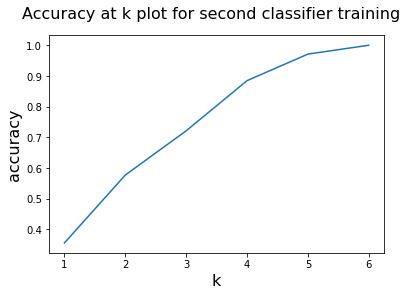

In [305]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot([1,2,3,4,5,6],accruacy_at_k_list)
fig.suptitle('Accuracy at k plot for second classifier training', fontsize=16)
plt.xlabel('k', fontsize=16)
plt.ylabel('accuracy', fontsize=16)

----------------- 0.30000000000000004 -------------------
precision: 0.5021330883853847
recall: 0.9315789473684211
f1: 0.6525138174739478
accuracy: 0.5039473684210527
0.5021330883853847
----------------- 0.4 -------------------
precision: 0.5001906765097364
recall: 0.868421052631579
f1: 0.6346503018584524
accuracy: 0.5
0.5001906765097364
----------------- 0.5 -------------------
precision: 0.491508089784866
recall: 0.5236842105263158
f1: 0.5064778272541985
accuracy: 0.49078947368421055
0.491508089784866
----------------- 0.6000000000000001 -------------------
precision: 0.6091224951519069
recall: 0.23947368421052628
f1: 0.3419889486926112
accuracy: 0.5407894736842105
0.6091224951519069
----------------- 0.7000000000000001 -------------------
precision: 0.8821428571428571
recall: 0.1394736842105263
f1: 0.24019783272563858
accuracy: 0.5592105263157895
0.8821428571428571
----------------- 0.8 -------------------
precision: 1.0
recall: 0.039473684210526314
f1: 0.07540337711069418
accuracy:

C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metr

----------------- 0.9 -------------------
precision: 0.0
recall: 0.0
f1: 0.0
accuracy: 0.5
0.0


C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'precision')

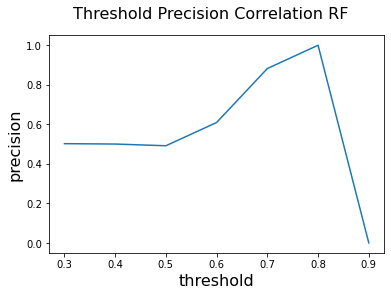

In [65]:
#plot Threshold Precision Correlation
test_classifiers = [RF]
test_classifiers_flag = ['RF']
precision_line,thresh_line = [],[]

#find threshold correlation with precision
for j in range(7):
    thresh = 0.1*(j+3)
    thresh_line.append(thresh)
    precision = ave_score(cluster_df_1, thresh)
    precision_line.append(precision)
    print(precision)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(thresh_line,precision_line)
fig.suptitle('Threshold Precision Correlation '+test_classifiers_flag[0], fontsize=16)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('precision', fontsize=16)

----------------- 0.30000000000000004 -------------------
precision: 0.48885410550999675
recall: 0.851388888888889
f1: 0.621041975640692
accuracy: 0.48413793103448277
0.48885410550999675
----------------- 0.4 -------------------
precision: 0.509603279361732
recall: 0.7722222222222221
f1: 0.6139455060941877
accuracy: 0.5179310344827586
0.509603279361732
----------------- 0.5 -------------------
precision: 0.5250196002486425
recall: 0.5833333333333334
f1: 0.5523010768894715
accuracy: 0.5310344827586208
0.5250196002486425
----------------- 0.6000000000000001 -------------------
precision: 0.5789199841552783
recall: 0.39583333333333337
f1: 0.46960352522080695
accuracy: 0.5572413793103448
0.5789199841552783
----------------- 0.7000000000000001 -------------------
precision: 0.5944889930893986
recall: 0.2555555555555556
f1: 0.3566390764705562
accuracy: 0.5448275862068966
0.5944889930893986
----------------- 0.8 -------------------
precision: 0.5800541058528675
recall: 0.15833333333333333
f1:

Text(0, 0.5, 'precision')

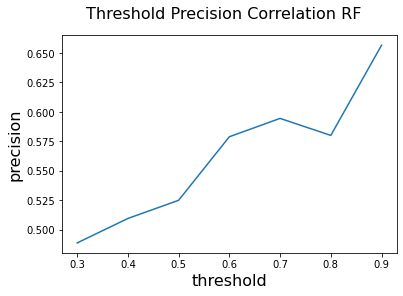

In [160]:
#plot Threshold Precision Correlation
test_classifiers = [RF]
test_classifiers_flag = ['RF']
precision_list, recall_list, f1_list, accuracy_list = [],[],[],[]
precision_line,thresh_line = [],[]

#find threshold correlation with precision
for j in range(7):
    thresh = 0.1*(j+3)
    thresh_line.append(thresh)
    precision = ave_score(cluster_df_1, thresh)
    precision_line.append(precision)
    print(precision)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(thresh_line,precision_line)
fig.suptitle('Threshold Precision Correlation '+test_classifiers_flag[0], fontsize=16)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('precision', fontsize=16)